In [1]:
using DifferentialEquations
include("src/Utils.jl")
include("src/Models.jl")
include("src/Params.jl");
using Plots; gr();

## Add leakiness to only the kinase terms

In [2]:
function kaiabc_phong_leaky!(dX, X, p, t)

    # U: unphosphorylated. T: only T432 phosphorylated. S: only S431 phosphorylated
    # D: doubly phosphorylated. DB: D KaiC bound with KaiB. SB: S KaiC bound with KaiB
    U, T, D, S, DB, SB = X

    # k's are reaction constants (here all are 1st-order), e.g., 
    # kTU is the per reactant rate transfering from T to U
    # kCIhyd: ATP hydrolysis rate of the CI ring
    # KA: [KaiA] that activates kinase activity to half maximum
    # A0: initial [KaiA]
    # fATP = [ATP] / ([ATP] + [ADP])
    # N: # A sequestered per D. M: # A sequestered per S
    kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
    KA, A0, fATP, N, M, ϵ = p

    hill(x) = x/(x + KA)
    hill_leaky(x) = ϵ + (1 - ϵ)*hill(x)

    # KaiA sequestration
    A = max(0, A0 - N*DB - M*SB)

    #           U,      T,      D,      S,      DB,     SB
    dephos_r  = [0      kTU     0       kSU     0       kSU
                 0      0       kDT     0       kDT     0
                 0      0       0       0       0       0
                 0      0       kDS     0       0       0
                 0      0       0       0       0       0
                 0      0       0       0       kDS     0] +
                [0      kTUA    0       kSUA    0       kSUA
                 0      0       kDTA    0       kDTA    0
                 0      0       0       0       0       0
                 0      0       kDSA    0       0       0
                 0      0       0       0       0       0
                 0      0       0       0       kDSA    0]*hill(A)
    
    #         U     T       D       S       DB      SB
    phos_r = [0     0       0       0       0       0
              kUTA  0       0       0       0       0
              0     kTDA    0       kSDA    0       0
              kUSA  0       0       0       0       0
              0     0       0       0       0       kSDA
              0     0       0       0       0       0]*hill_leaky(A)*fATP

    #        U      T       D       S       DB      SB
    hyd_r = [0      0       0       0       0       0
             0      0       0       0       0       0
             0      0       0       0       0       0
             0      0       0       0       0       0
             0      0       kCIhyd  0       0       0
             0      0       0       kCIhyd  0       0]

    r = dephos_r + phos_r + hyd_r

    # conservation
    r -= I(size(r)[1]) .* sum(r, dims=1)

    # (for AD) Zygote.Buffer doesn't support in-place broadcast .=
    # see https://discourse.julialang.org/t/how-to-use-initialize-zygote-buffer/87653
    dX[:] = r*X
    nothing
end

kaiabc_phong_leaky! (generic function with 1 method)

Check out the trajectories

In [29]:
kSU

0.1

In [38]:
A0 = 1.0
fATP = 1.0

kSU_cold = 0.02


p_ori = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU_cold, kSUA, kUSA, kCIhyd,
KA, A0, fATP, N, M);

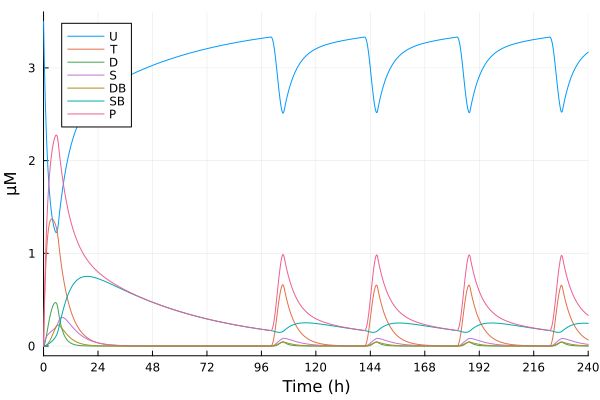

In [39]:
# U, T, D, S, DB, SB
p0 = [3.5, 0, 0, 0, 0, 0]

tmax = 240

prob = ODEProblem(kaiabc_phong!, p0, (0.0, tmax), p_ori)
sol = solve(prob, saveat = 0.1)

plot(sol, labels=["U" "T" "D" "S" "DB" "SB"])
plot!(sol.t, 3.5*phospho_C(sol.u), label="P")
xticks!(0:24:tmax)
xlabel!("Time (h)")
ylabel!("μM")

Period and amplitude as a function of leakiness (\[KaiA\] = 1.0 uM which gives a period around 21 hours)

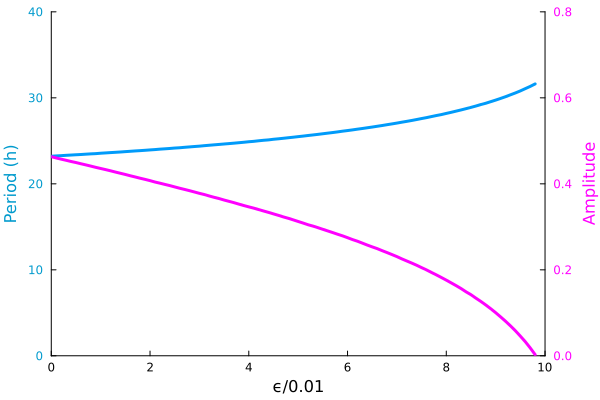

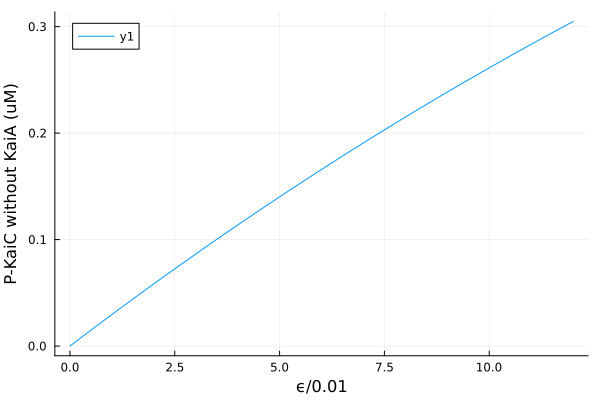

In [5]:
ϵ_vec = 0.0:1e-3:0.12

# initial conditions
u0 = [3.5, 0, 0, 0, 0, 0]

# additional params
A0 = 1.0
fATP = 1.0

p_ori = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
KA, A0, fATP, N, M);

# find period numerically
per_mat = zeros(length(ϵ_vec))
amp_mat = zeros(length(ϵ_vec))
pss_vec = zeros(length(ϵ_vec))
    
p0 = [1, 0, 0]

for (i, ϵ) in enumerate(ϵ_vec)
    converge, amplitude, per, phase = 
    attracted_to(kaiabc_phong_leaky!, u0, 168, (p_ori..., ϵ); burnin=96, conv_tol=5e-2, amp_cutoff=1e-3, tmax_stop=1e3)
    per_mat[i] = per == -1 ? NaN : per
    amp_mat[i] = amplitude == -1 ? NaN : amplitude
    
    # steady state p-KaiC without KaiA
    p_new = [x for x in p_ori]
    p_new[15] = 0.0
    prob = ODEProblem(kaiabc_phong_leaky!, u0, (0, 120), (p_new..., ϵ))
    sol = solve(prob, reltol=1e-8, abstol=1e-8, saveat=1)
    pss = phospho_C(sol.u)
    pss_vec[i] = sum(pss[(length(pss) - 9):length(pss)])/10
end

p = plot(ϵ_vec*100, per_mat; legend=false, linewidth=3, framestyle=:box, grid=false,
yguidefontcolor="deepskyblue3", ytickfontcolor="deepskyblue3", ylabel="Period (h)", ylims=(0, 40))
xlabel!("ϵ/0.01")
xlims!(0.0, 10.0)
plot!(twinx(p), 100ϵ_vec, amp_mat; legend=false, linewidth=3, color="magenta",
tickfontcolor="magenta", yguidefontcolor="magenta", ylabel="Amplitude", ylims=(0.0, 0.8), xlims=(0, 10))
display(p)

plot(100ϵ_vec, pss_vec, xlabel="ϵ/0.01", ylabel="P-KaiC without KaiA (uM)")

Map x-axis to steady-state P-KaiC without KaiA

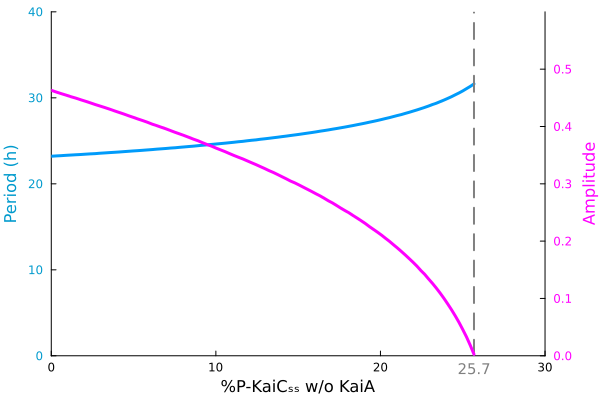

In [6]:
p = plot(100pss_vec, per_mat; legend=false, linewidth=3, framestyle=:box, grid=false,
yguidefontcolor="deepskyblue3", ytickfontcolor="deepskyblue3", ylabel="Period (h)", ylims=(0, 40))
xlabel!("%P-KaiCₛₛ w/o KaiA")
xlims!(0.0, 30.0)

plot!(twinx(p), 100pss_vec, amp_mat; legend=false, linewidth=3, color="magenta",
tickfontcolor="magenta", yguidefontcolor="magenta", ylabel="Amplitude", ylims=(0.0, 0.6), xlims=(0, 30))

# mark bifurcation
pss_max = last([ pss_vec[i] for i in 1:length(pss_vec) if per_mat[i] > 0 ])
vline!(p, [100pss_max], linestyle=:dash, color=:gray, linewidth=2)
annotate!(p, [100pss_max], [-1.5], "$(round(100pss_max, digits=1))"; annotationcolor=:gray, annotationfontsize=10)
display(p)
